In [238]:
#Imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Conv2D,MaxPool2D,Dense,Dropout
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [239]:
# Loading the MNIST dataset
mnist_dataset = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist_dataset.load_data()

In [241]:
#Reshape and Scale

training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

### Model without MC Dropout

In [242]:
def cnn_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [2,3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    MaxPool2D(2,2),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [2,3,5]),
        activation='relu'
    ),
    MaxPool2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [ ]:
# Hyperparameter Tuning

tuner_search=RandomSearch(cnn_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="Mnist_Dataset")

tuner_search.search(training_images,training_labels,epochs=3,validation_split=0.1)

In [245]:
# Getting the best model
model=tuner_search.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 48)                3

In [246]:
model.fit(training_images,training_labels,epochs=10)
model.save("models/model_withoutMC_mnistTrained.h5")

Epoch 1/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0406 - accuracy: 0.9876
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0317 - accuracy: 0.9898
Epoch 3/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0240 - accuracy: 0.9924
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0197 - accuracy: 0.9939
Epoch 5/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0164 - accuracy: 0.9949
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0131 - accuracy: 0.9957
Epoch 7/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0122 - accuracy: 0.9959
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0099 - accuracy: 0.9968
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0090 - accuracy: 0.9969
Epoch 10/10
1875/1875 [==============================] - 15s 8ms/step - l

In [248]:
model_stats = model.evaluate(test_images,test_labels)
print("Accuracy of CNN model without MC dropout (MNIST dataset) :" , model_stats[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0489 - accuracy: 0.9889
Accuracy of CNN model without MC dropout (MNIST dataset) : 0.9889000058174133


### Model with MC Dropout

In [249]:
# Creating model with MC dropput, using hypertuned parameters

def cnn_model_mc():  
  model = Sequential([
    Conv2D(32,(5,5),input_shape=(28,28,1),activation='relu'),
    Dropout(0.4),
    MaxPool2D(2,2),
    Conv2D(32,(3,3),input_shape=(28,28,1),activation='relu'),
    Dropout(0.4),
    MaxPool2D(2,2),
    Flatten(),
    Dense(48, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
  ])
  
  model.compile(
  optimizer='Adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
  )
  
  return model

In [250]:
model_mc = cnn_model_mc()
model_mc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                  

In [251]:
model_mc.fit(training_images,training_labels,epochs=10)
model_mc.save("models/model_withMC_mnistTrained.h5")

Epoch 1/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.3131 - accuracy: 0.9017
Epoch 2/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1265 - accuracy: 0.9626
Epoch 3/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1010 - accuracy: 0.9706
Epoch 4/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0897 - accuracy: 0.9729
Epoch 5/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0796 - accuracy: 0.9760
Epoch 6/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0746 - accuracy: 0.9785
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0701 - accuracy: 0.9790
Epoch 8/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0658 - accuracy: 0.9809
Epoch 9/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0628 - accuracy: 0.9812
Epoch 10/10
1875/1875 [==============================] - 27s 14m

In [252]:
prediction_stack_mc = np.stack([model_mc(test_images,training=True)
                   for sample in range(100)])

In [253]:
prediction_mean = prediction_stack_mc.mean(axis = 0)
prediction_std = prediction_stack_mc.std(axis = 0)

In [254]:
prediction = np.argmax(prediction_mean , axis = 1)
accuracy = sum(prediction == test_labels) / len(test_labels)

In [255]:
print("Accuracy with MC dropout with 100 iterations in testing :", accuracy)

Accuracy with MC dropout with 100 iterations in testing : 0.9917


### Subtask a.

In [256]:
# Removing last layer of my model without MC
model = load_model('models/model_withoutMC_mnistTrained.h5')
model_without_last_layer = Sequential(model.layers[:-1])

In [257]:
# Getting the model's new outputs
model_outputs = model_without_last_layer.predict(test_images)

313/313 [==============================] - 1s 3ms/step


In [258]:
# Compute t-SNE embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(model_outputs)

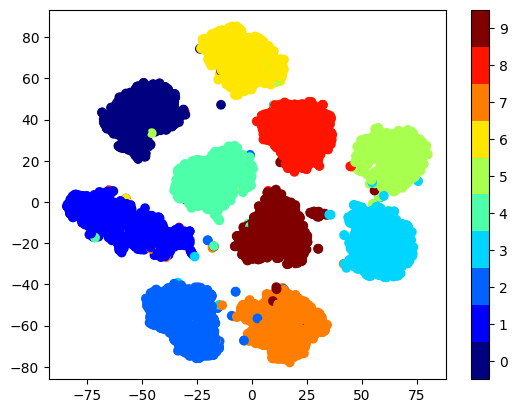

In [259]:
# Plot the t-SNE plot
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=test_labels, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

### Subtask b.

In [260]:
# Load fashion mnist dataset

mnist_dataset_fashion = tf.keras.datasets.fashion_mnist
(training_images_fashion, training_labels_fashion), (test_images_fashion, test_labels_fashion) = mnist_dataset_fashion.load_data()

In [261]:
training_images_fashion=training_images_fashion.reshape(60000, 28, 28, 1)
training_images_fashion=training_images_fashion / 255.0
test_images_fashion = test_images_fashion.reshape(10000, 28, 28, 1)
test_images_fashion=test_images_fashion/255.0

Using the model trained on MNIST dataset

In [313]:
model_mc = load_model('models/model_withMC_mnistTrained.h5')

In [314]:
prediction_stack_mc = np.stack([model_mc(test_images_fashion,training=True)
                   for sample in range(100)])

In [315]:
prediction_mean = prediction_stack_mc.mean(axis = 0)
prediction_std = (prediction_stack_mc).std(axis=2).mean(axis=0)

prediction = np.argmax(prediction_mean , axis = 1)
accuracy = sum(prediction == test_labels_fashion) / len(test_labels_fashion)

In [316]:
#Using the concept of entropy and variance to calculate a measure of uncertainity

predictive_entropy = (-prediction_stack_mc * np.log(prediction_stack_mc)).sum(axis=2).mean(axis=0)
predictive_entropy = np.nan_to_num(predictive_entropy, nan=0.0) 

In [317]:
print("The average variance for each prediction(a form of uncertainity) :" , prediction_std)

print("The uncertainity(entropy) for each prediction :" , predictive_entropy)

uncertainty_entropy = predictive_entropy.mean()
print("Average Uncertainty across the tests(standard deviation of predictive entropy):", uncertainty_entropy)

print("Accuracy of the model :" , accuracy)

The average variance for each prediction(a form of uncertainity) : [0.26300514 0.24211177 0.2269969  ... 0.16625433 0.23489672 0.14443341]
The uncertainity(entropy) for each prediction : [0.34840667 0.581479   0.7054053  ... 1.2388569  0.62063754 1.5187188 ]
Average Uncertainty across the tests(standard deviation of predictive entropy): 0.99848723
Accuracy of the model : 0.1056


Training the model on the MNIST fashion dataset itself: 

In [302]:
model_mc = cnn_model_mc()

In [303]:
model_mc.fit(training_images_fashion,training_labels_fashion,epochs=10)
model_mc.save("models/model_withMC_mnistFashionTrained.h5")

Epoch 1/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.6743 - accuracy: 0.7505
Epoch 2/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.4838 - accuracy: 0.8241
Epoch 3/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.4315 - accuracy: 0.8436
Epoch 4/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.4001 - accuracy: 0.8555
Epoch 5/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3829 - accuracy: 0.8619
Epoch 6/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3680 - accuracy: 0.8668
Epoch 7/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3574 - accuracy: 0.8697
Epoch 8/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3480 - accuracy: 0.8728
Epoch 9/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3379 - accuracy: 0.8765
Epoch 10/10
1875/1875 [==============================] - 21s 11m

In [304]:
prediction_stack_mc = np.stack([model_mc(test_images_fashion,training=True)
                   for sample in range(100)])

In [305]:
prediction_mean = prediction_stack_mc.mean(axis = 0)
prediction_std = (prediction_stack_mc).std(axis=2).mean(axis=0)

prediction = np.argmax(prediction_mean , axis = 1)
accuracy = sum(prediction == test_labels_fashion) / len(test_labels_fashion)

In [ ]:
#Using the concept of entropy and variance to calculate a measure of uncertainity

predictive_entropy = (-prediction_stack_mc * np.log(prediction_stack_mc)).sum(axis=2).mean(axis=0)
predictive_entropy = np.nan_to_num(predictive_entropy, nan=0.0) 

In [308]:
print("The average variance for each prediction(a form of uncertainity) :" , prediction_std)

print("The uncertainity(entropy) for each prediction :" , predictive_entropy)

uncertainty_entropy = predictive_entropy.mean()
print("Average Uncertainty across the tests(standard deviation of predictive entropy):", uncertainty_entropy)

print("Accuracy of the model :" , accuracy)

The average variance for each prediction(a form of uncertainity) : [0.29707313 0.2908978  0.29998198 ... 0.2984008  0.29931396 0.22707577]
The uncertainity(entropy) for each prediction : [0.03247189 0.         0.         ... 0.01999399 0.         0.67041624]
Average Uncertainty across the tests(standard deviation of predictive entropy): 0.2529331
Accuracy of the model : 0.9019


#### Subtask c.

In [286]:
# Creating the model without dropout

def cnn_model():  
  model = Sequential([
    Conv2D(32,(5,5),input_shape=(28,28,1),activation='relu'),
    MaxPool2D(2,2),
    Conv2D(32,(3,3),input_shape=(28,28,1),activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(20, activation='softmax')
  ])
  
  model.compile(
  optimizer='Adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
  )
  
  return model

In [287]:
model = cnn_model()

In [288]:
# Changing the fashion mnist data so that the labels are different from the mnist data

mnist_dataset = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist_dataset.load_data()

mnist_dataset_fashion = tf.keras.datasets.fashion_mnist
(training_images_fashion, training_labels_fashion), (test_images_fashion, test_labels_fashion) = mnist_dataset_fashion.load_data()

In [289]:
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

In [290]:
training_images_fashion=training_images_fashion.reshape(60000, 28, 28, 1)
training_images_fashion=training_images_fashion / 255.0
test_images_fashion = test_images_fashion.reshape(10000, 28, 28, 1)
test_images_fashion=test_images_fashion/255.0

In [291]:
training_labels_fashion_new = []
test_labels_fashion_new = []

for i in range(len(training_labels_fashion)):
    training_labels_fashion_new.append(training_labels_fashion[i] + 10)


for i in range(len(test_labels_fashion)):
    test_labels_fashion_new.append(test_labels_fashion[i] + 10)

In [292]:
training_labels_fashion_new = np.array(training_labels_fashion_new)
test_labels_fashion_new = np.array(test_labels_fashion_new)

In [293]:
combined_training_images = np.concatenate((training_images, training_images_fashion), axis=0)
combined_training_labels = np.concatenate((training_labels, training_labels_fashion_new), axis=0)

In [294]:
combined_test_images = np.concatenate((test_images, test_images_fashion), axis=0)
combined_test_labels = np.concatenate((test_labels, test_labels_fashion_new), axis=0)

In [295]:
model.fit(combined_training_images,combined_training_labels,epochs=10)
model.save("models/model_withoutMC_mnistTrained_fashionTrained.h5")

Epoch 1/10
3750/3750 [==============================] - 30s 8ms/step - loss: 0.3402 - accuracy: 0.8851
Epoch 2/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.1939 - accuracy: 0.9319
Epoch 3/10
3750/3750 [==============================] - 29s 8ms/step - loss: 0.1648 - accuracy: 0.9415
Epoch 4/10
3750/3750 [==============================] - 30s 8ms/step - loss: 0.1479 - accuracy: 0.9469
Epoch 5/10
3750/3750 [==============================] - 29s 8ms/step - loss: 0.1357 - accuracy: 0.9507
Epoch 6/10
3750/3750 [==============================] - 29s 8ms/step - loss: 0.1244 - accuracy: 0.9548
Epoch 7/10
3750/3750 [==============================] - 28s 8ms/step - loss: 0.1165 - accuracy: 0.9571
Epoch 8/10
3750/3750 [==============================] - 28s 8ms/step - loss: 0.1095 - accuracy: 0.9594
Epoch 9/10
3750/3750 [==============================] - 29s 8ms/step - loss: 0.1036 - accuracy: 0.9616
Epoch 10/10
3750/3750 [==============================] - 28s 8ms/step - l

In [282]:
#Removing the last layer
model_without_last_layer = Sequential(model.layers[:-1])

In [283]:
# Getting the model's outputs
model_outputs = model_without_last_layer.predict(combined_test_images)

625/625 [==============================] - 2s 3ms/step


In [284]:
# Compute t-SNE embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(model_outputs)

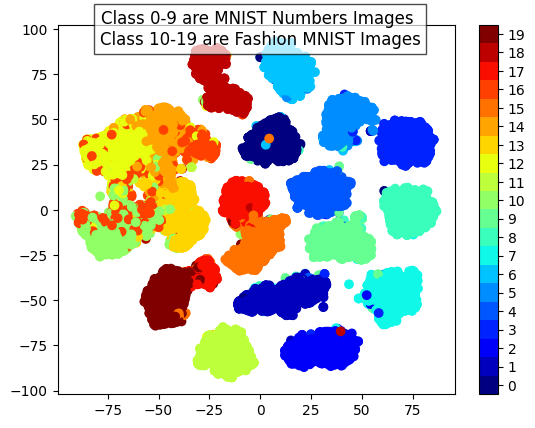

In [285]:
# Plot the t-SNE plot
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=combined_test_labels, cmap=plt.cm.get_cmap("jet", 20))
plt.colorbar(ticks=range(20))
plt.clim(-0.5, 19.5)
plt.text(0, 100, "Class 0-9 are MNIST Numbers Images \nClass 10-19 are Fashion MNIST Images",
         fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))
plt.show()